In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450,2000],[450,2000],[450,2000]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [15]:
exp_ids=['2018_07_01_16_16_58_Ryd 780A RFE, 8us FORT drop',
         '2018_07_01_16_24_23_Ryd 780A RFE, 4 us FORT drop'
        ]
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_07_01/2018_07_01_16_16_58_Ryd 780A RFE, 8us FORT drop/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_07_01/2018_07_01_16_24_23_Ryd 780A RFE, 4 us FORT drop/qdp.txt


# Experiment-wise analysis

<IPython.core.display.Javascript object>


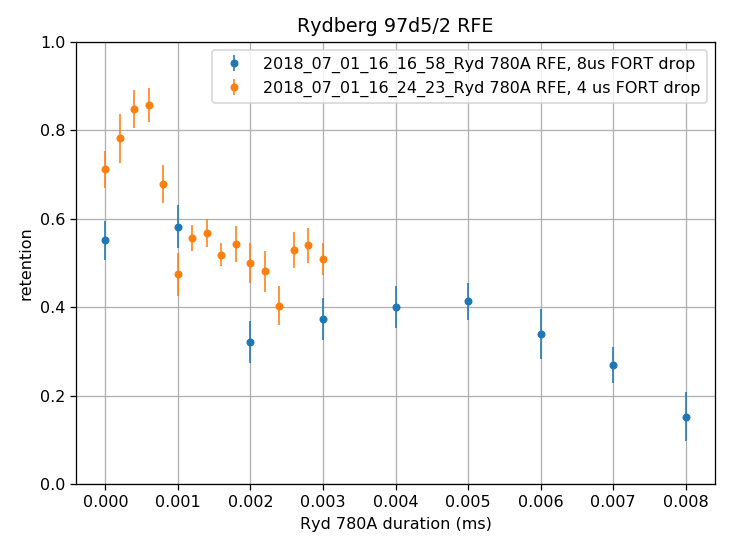

In [18]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, ax = plt.subplots()
assorted_data=[]
assorted_reten=[]
assorted_err=[]
for i in [0,1]:
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()

    fitted_parameters=[]
    for roi in [2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        
        ax.errorbar(data,reten,yerr=err,label="{}".format(exp_id),fmt='o',lw=1,markersize=4,color=colors[i])
        #ax.errorbar(data,reten,yerr=err,label="{}".format(exp_id),fmt='o',lw=1,markersize=4,color=colors[0])
    assorted_data.append(data)
    assorted_reten.append(reten)
    assorted_err.append(err)
plt.show()
#ax.set_title(exp_id)
ax.set_title('Rydberg 97d5/2 RFE')
ax.set_ylim(0, 1.0)
ax.grid()
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()
plt.tight_layout()
plt.savefig('{}.pdf'.format(exp_id))
plt.savefig('{}.png'.format(exp_id))

<IPython.core.display.Javascript object>


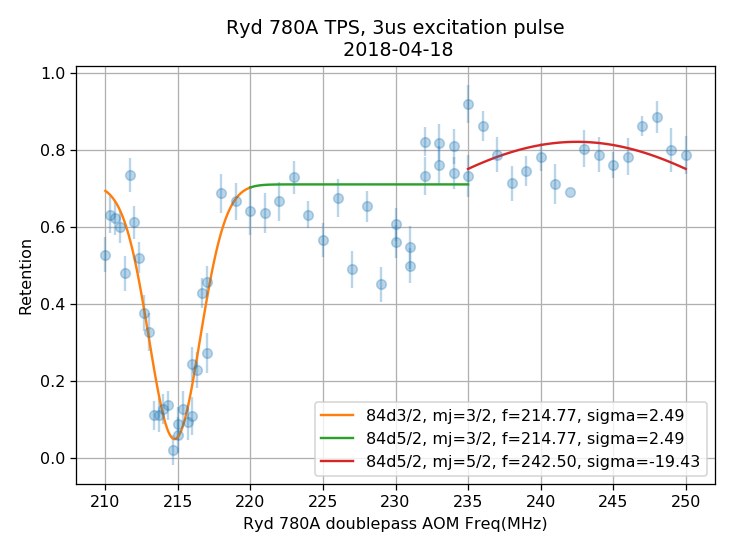

center:214.769019683, width:2.48838623508
center:214.769020286, width:2.48837949205
center:242.500081517, width:-19.4255612153


In [34]:
list_of_lists=assorted_data
flattened_data = [val for sublist in list_of_lists for val in sublist]
list_of_lists=assorted_reten
flattened_reten = [val for sublist in list_of_lists for val in sublist]
list_of_lists=assorted_err
flattened_err = [val for sublist in list_of_lists for val in sublist]
fig, ax = plt.subplots()
ax.errorbar(flattened_data, flattened_reten,yerr=flattened_err,fmt='o',alpha=0.3)

fit_guesses=[-0.8, 215, 5 , 0.9]
fit,pcov = curve_fit(gaussian,flattened_data,flattened_reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
xarray=np.linspace(210,220,100)
yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
print "center:{}, width:{}".format(fit[1],fit[2])
plt.plot(xarray,yfit,label='84d3/2, mj=3/2, f={0:.2f}, sigma={1:.2f}'.format(fit[1],fit[2]))

fit_guesses=[-0.35, 227.5, 4 , 0.7]
fit,pcov = curve_fit(gaussian,flattened_data,flattened_reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
xarray=np.linspace(220,235,100)
yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
print "center:{}, width:{}".format(fit[1],fit[2])
plt.plot(xarray,yfit,label='84d5/2, mj=3/2, f={0:.2f}, sigma={1:.2f}'.format(fit[1],fit[2]))

fit_guesses=[-0.1, 240, 5 , 0.9]
fit,pcov = curve_fit(gaussian,flattened_data,flattened_reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
xarray=np.linspace(235,250,100)
yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
print "center:{}, width:{}".format(fit[1],fit[2])
plt.plot(xarray,yfit,label='84d5/2, mj=5/2, f={0:.2f}, sigma={1:.2f}'.format(fit[1],fit[2]))

ax.set_title('Ryd 780A TPS, 3us excitation pulse\n 2018-04-18')
#ax.set_ylim(0, 1)
ax.grid()
ax.set_xlabel('Ryd 780A doublepass AOM Freq(MHz)')
ax.set_ylabel('Retention')
ax.legend()
plt.tight_layout()
#plt.savefig('{}.pdf'.format('20180418_Rydberg780A TPS assorted'))

center:229.073051341, width:0.23974024867
center:232.226245398, width:0.219684160698
center:236.915151095, width:0.964286421921
